In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os


# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     |████████████████████████████████| 993kB 48.1MB/s 


In [3]:
from google.colab import drive as mount_drive
mount_drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
EgoCNN = drive.CreateFile({'id':'1LEhCom26NzOuzeGgShzUazvZsHNn-9yu'})
EgoCNN.GetContentFile('EgoCNN.py')
from EgoCNN import EgoCNN, EgoDense, EgoMobile, EgoResNet
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, Model
from keras.optimizers import SGD, Adam

import numpy as np
import h5py


Using TensorFlow backend.


In [0]:
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_path = 'gdrive/My Drive/cassava/train'
valid_path = 'gdrive/My Drive/cassava/validation'

In [0]:
def crop(im):
    if (im.size[1] > im.size[0]):
        crop_shift = int((im.size[1] - im.size[0])/2)
        im = im.crop((0, crop_shift, im.size[0], im.size[0] + crop_shift))
    elif (im.size[0] > im.size[1]):
        crop_shift = int((im.size[0] - im.size[1])/2)
        im = im.crop((crop_shift, 0, im.size[1] + crop_shift, im.size[1]))
        im = im.resize((224,224), resample=Image.LANCZOS)
    return im

In [8]:
model = load_model('gdrive/My Drive/cassava/model_data/egomob.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input0[0][0]                     
                                                                 input1[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 7, 7, 2560)   0           mobilenetv2_1.00_224[1][0]       
          

In [0]:
def classifier(model):
    input_img = Input(shape=(224,224,3))
    x = model.get_layer('mobilenetv2_1.00_224')(input_img)
    x = Conv2D(128, kernel_size=(2,2), activation='elu',
               kernel_regularizer=l2(0.0001),
               bias_regularizer=l2(0.0001))(x)
    x = Conv2D(128, kernel_size=(1,1), activation='elu',
               kernel_regularizer=l2(0.0001),
               bias_regularizer=l2(0.0001))(x)
    x = Conv2D(64, kernel_size=(1,1), activation='elu',
               kernel_regularizer=l2(0.0001),
               bias_regularizer=l2(0.0001))(x)
    x = Flatten()(x)
    x = Dropout(rate=.3)(x)
    x = Dense(200, activation='elu')(x)
    x = Dense(5, activation='softmax')(x)     
    return Model(input_img, x)

In [0]:
model = classifier(model)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         655488    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         16512     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2304)              0         
__________

In [0]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
cp_filepath = 'gdrive/My Drive/cassava/model_data/egoclassifier_mobile.hdf5'
checkpointer = ModelCheckpoint(cp_filepath, monitor='val_loss', verbose=0,
                               save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [0]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [23]:
batch_size = 32

# generators
train_generator = ImageDataGenerator(rotation_range=10,
                                     width_shift_range=10,
                                     height_shift_range=10,
                                     fill_mode='reflect',
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     brightness_range=[0.5, 1.5],
                                     channel_shift_range = 0.1,
                                     zoom_range=[0.9, 1.25],
                                     shear_range=0.01).flow_from_directory('gdrive/My Drive/cassava/train',
                                                                             target_size=(224, 224),
                                                                             classes=['cbb','cbsd','cgm','cmd','healthy'],
                                                                             class_mode='categorical',
                                                                             batch_size=batch_size,
                                                                             shuffle=True)
valid_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True).flow_from_directory('gdrive/My Drive/cassava/validation',
                                                                             target_size=(224, 224),
                                                                             classes=['cbb','cbsd','cgm','cmd','healthy'],
                                                                             class_mode='categorical',
                                                                             batch_size=batch_size,
                                                                             shuffle=True)


Found 3958 images belonging to 5 classes.
Found 1698 images belonging to 5 classes.


In [24]:
if os.path.isfile(cp_filepath):
    print('Loading model ' + cp_filepath)
    model = load_model(cp_filepath)
    history = model.fit_generator(train_generator,
                                  epochs=100,
                                  steps_per_epoch=3958//batch_size,
                                  validation_data=valid_generator,
                                  validation_steps=1698//batch_size,
                                  callbacks=[early_stop, checkpointer, reduce_lr])
else:
    history = model.fit_generator(train_generator,
                                  epochs=100,
                                  steps_per_epoch=3958//batch_size,
                                  validation_data=valid_generator,
                                  validation_steps=1698//batch_size, 
                                  #class_weight={0: 5.7, 1: 1.84, 2: 3.43, 3: 1.0, 4: 8.41},
                                  callbacks=[early_stop, checkpointer, reduce_lr])

Loading model gdrive/My Drive/cassava/model_data/egoclassifier_mobile.hdf5
Epoch 1/100
123/123 [==============================] - 75s 610ms/step - loss: 0.3849 - acc: 0.8844 - val_loss: 0.4993 - val_acc: 0.8414
Epoch 2/100
123/123 [==============================] - 63s 509ms/step - loss: 0.3728 - acc: 0.8824 - val_loss: 0.5023 - val_acc: 0.8361
Epoch 3/100
123/123 [==============================] - 64s 520ms/step - loss: 0.3682 - acc: 0.8905 - val_loss: 0.5128 - val_acc: 0.8379
Epoch 4/100
123/123 [==============================] - 64s 519ms/step - loss: 0.3586 - acc: 0.8926 - val_loss: 0.4961 - val_acc: 0.8427
Epoch 5/100
123/123 [==============================] - 78s 634ms/step - loss: 0.3646 - acc: 0.8863 - val_loss: 0.4995 - val_acc: 0.8463
Epoch 6/100
123/123 [==============================] - 65s 529ms/step - loss: 0.3389 - acc: 0.8958 - val_loss: 0.4923 - val_acc: 0.8415
Epoch 7/100
123/123 [==============================] - 64s 524ms/step - loss: 0.3345 - acc: 0.8946 - val_loss

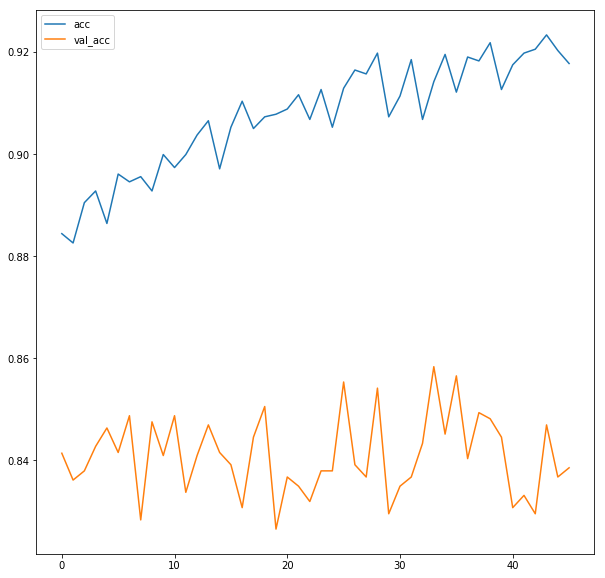

In [25]:
metrics = ['acc', 'val_acc']
plt.figure(figsize=(10,10))
for met in metrics:
    plt.plot(history.history[met])
plt.legend(metrics)